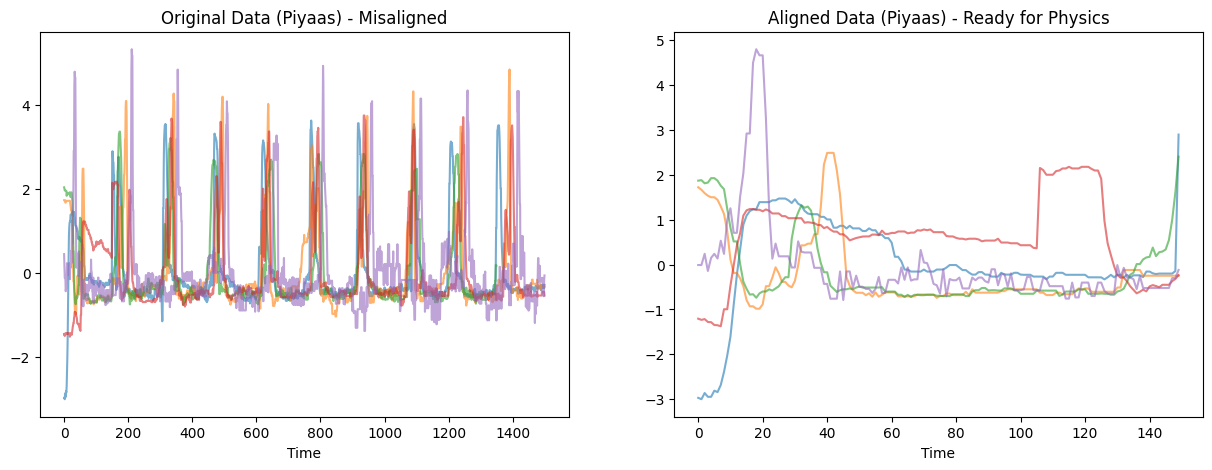

In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

# ==========================================
# 1. Define Alignment Function
# ==========================================
def align_and_crop(theta, window_size=150, threshold=0.5):
    """
    Finds where the jaw actually starts moving and crops 150 frames from there.
    """
    # Normalize to 0-1 range for consistent thresholding
    theta_norm = (theta - np.min(theta)) / (np.max(theta) - np.min(theta) + 1e-6)
    
    # Calculate Energy (Rolling Standard Deviation)
    # This detects "Activity" vs "Silence"
    energy = pd.Series(theta_norm).rolling(window=10).std().fillna(0).values
    
    # Find the first time energy crosses the threshold
    # We use a low threshold (0.02) to catch the *start* of movement
    active_indices = np.where(energy > 0.05)[0]
    
    if len(active_indices) == 0:
        start_idx = 0 # Fallback
    else:
        start_idx = max(0, active_indices[0] - 10) # Start 10 frames before activity
        
    # Crop
    end_idx = start_idx + window_size
    
    # Pad if file is too short
    if end_idx > len(theta):
        crop = theta[start_idx:]
        pad = np.zeros(window_size - len(crop))
        # Pad with the LAST value to prevent "jump" artifacts
        pad[:] = crop[-1] if len(crop) > 0 else 0
        crop = np.concatenate([crop, pad])
    else:
        crop = theta[start_idx:end_idx]
        
    return crop

# ==========================================
# 2. Visualize the Fix (Sanity Check)
# ==========================================
src_pattern = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset1/recordings/*/*.csv'
files = glob.glob(src_pattern)

# Pick a random word to check
target_word = "Piyaas" # Or any word you like
examples = [f for f in files if target_word in f][:5]

plt.figure(figsize=(15, 5))

# Plot 1: Original (Messy)
plt.subplot(1, 2, 1)
for fp in examples:
    df = pd.read_csv(fp)
    plt.plot(df['theta'].values, alpha=0.6)
plt.title(f"Original Data ({target_word}) - Misaligned")
plt.xlabel("Time")

# Plot 2: Aligned (Clean)
plt.subplot(1, 2, 2)
for fp in examples:
    df = pd.read_csv(fp)
    theta_clean = align_and_crop(df['theta'].values)
    plt.plot(theta_clean, alpha=0.6)
plt.title(f"Aligned Data ({target_word}) - Ready for Physics")
plt.xlabel("Time")

plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import glob
import os
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# ==========================================
# CONFIGURATION
# ==========================================
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float64) # Precision
DATA_PATH = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset1/recordings/*/*.csv'

# ==========================================
# 1. DATA PREPARATION (The Fix)
# ==========================================
def align_signal(theta, x, y, window=150):
    # Energy Detection on Theta
    norm = (theta - theta.min()) / (theta.max() - theta.min() + 1e-6)
    energy = pd.Series(norm).rolling(10).std().fillna(0).values
    active = np.where(energy > 0.05)[0]
    
    start = max(0, active[0]-10) if len(active) > 0 else 0
    end = start + window
    
    # Crop all channels
    def crop_channel(arr):
        c = arr[start:end]
        if len(c) < window:
            pad = np.full(window-len(c), c[-1] if len(c)>0 else 0)
            return np.concatenate([c, pad])
        return c

    return crop_channel(theta), crop_channel(x), crop_channel(y)

print("Loading and Aligning Data...")
files = glob.glob(DATA_PATH)
theta_dict, embed_time_dict = {}, {}
X_cnn_train, y_cnn_train = [], []
labels_map = {}

t = torch.linspace(0, 1, 150, device=device).unsqueeze(-1)
file_metadata = [] # To keep track of IDs

# Global Normalization Stats
all_thetas = []

for fp in files:
    try:
        df = pd.read_csv(fp)
        if len(df) < 20: continue # Skip empty files
        
        # 1. ALIGN
        th_ali, x_ali, y_ali = align_signal(df['theta'].values, df['x'].values, df['y'].values)
        all_thetas.append(th_ali)
        
        # Store for later
        word = os.path.basename(os.path.dirname(fp))
        speaker = os.path.basename(fp).split('_')[0]
        fid = f"{word}::{speaker}::{os.path.basename(fp)}"
        
        file_metadata.append({
            'id': fid, 'theta': th_ali, 'x': x_ali, 'y': y_ali, 'label': word
        })
        
    except: continue

# Global Theta Scale (Important for PINN)
all_thetas = np.concatenate(all_thetas)
th_min, th_max = np.min(all_thetas), np.max(all_thetas)
print(f"Data Aligned. Global Theta Range: [{th_min:.2f}, {th_max:.2f}]")

# ==========================================
# 2. TRAIN CNN (Feature Extractor)
# ==========================================
# We train this FIRST to ensure embeddings are good
print("\n[Step 2] Training Feature Extractor (CNN)...")

# Prepare CNN Data
cnn_X = []
cnn_y = []
for item in file_metadata:
    # Stack [Theta, X, Y] -> Shape [3, 150]
    # Normalize per instance
    raw = np.vstack([item['theta'], item['x'], item['y']])
    norm = (raw - raw.mean(axis=1, keepdims=True)) / (raw.std(axis=1, keepdims=True) + 1e-6)
    cnn_X.append(norm)
    cnn_y.append(item['label'])

cnn_X = torch.tensor(np.array(cnn_X), dtype=torch.float64).to(device) # [N, 3, 150]

# Encode Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cnn_y_enc = torch.tensor(le.fit_transform(cnn_y), dtype=torch.long).to(device)

# CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(3, 64, 7, padding=3), nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding=2), nn.BatchNorm1d(128), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.head = nn.Linear(128, num_classes)
    def forward(self, x):
        feat = self.enc(x).squeeze(-1)
        return self.head(feat), F.normalize(feat, dim=1) # Return logits AND embedding

cnn = CNN(len(le.classes_)).to(device)
opt_cnn = optim.Adam(cnn.parameters(), lr=0.001)

# Training Loop
for epoch in range(100):
    cnn.train()
    logits, _ = cnn(cnn_X)
    loss = nn.CrossEntropyLoss()(logits, cnn_y_enc)
    opt_cnn.zero_grad()
    loss.backward()
    opt_cnn.step()
    if epoch % 20 == 0: print(f"CNN Epoch {epoch} Loss: {loss.item():.4f}")

print("✅ CNN Trained. Now Generating Embeddings for PINN...")

# ==========================================
# 3. PREPARE PINN INPUTS
# ==========================================
cnn.eval()
with torch.no_grad():
    _, embeddings = cnn(cnn_X) # Get all embeddings at once

# Populate Dictionaries for PINN
for i, item in enumerate(file_metadata):
    fid = item['id']
    
    # Target: Normalized Theta [-1, 1]
    th_norm = 2 * (item['theta'] - th_min) / (th_max - th_min) - 1
    theta_dict[fid] = torch.tensor(th_norm, device=device).unsqueeze(-1)
    
    # Input: Time + Embedding
    # Emb is [128], expand to [150, 128]
    emb_expanded = embeddings[i].unsqueeze(0).repeat(150, 1)
    pinn_input = torch.cat([t, emb_expanded], dim=1)
    embed_time_dict[fid] = pinn_input



Loading and Aligning Data...
Data Aligned. Global Theta Range: [-8.56, 8.93]

[Step 2] Training Feature Extractor (CNN)...
CNN Epoch 0 Loss: 3.2435
CNN Epoch 20 Loss: 3.1109
CNN Epoch 40 Loss: 3.0250
CNN Epoch 60 Loss: 2.9073
CNN Epoch 80 Loss: 2.7475
✅ CNN Trained. Now Generating Embeddings for PINN...


In [ ]:
# ==========================================
# 4. TRAIN PINN
# ==========================================
print("\n[Step 3] Training PINN...")

class PINN(nn.Module):
    def __init__(self, in_dim=129): # 1 Time + 128 Emb
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.Tanh(),
            nn.Linear(128, 128), nn.Tanh(),
            nn.Linear(128, 2) # Output: Theta_pred, Force_pred
        )
        self.b = nn.Parameter(torch.tensor(0.5))
        self.k1 = nn.Parameter(torch.tensor(2.0))
        self.k2 = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        out = self.net(x)
        return out[:, 0:1], out[:, 1:2] # Split theta/force

pinn = PINN().to(device)
opt_pinn = optim.Adam(pinn.parameters(), lr=0.001)

# Dataset
class SimpleDataset(Dataset):
    def __init__(self, t_d, e_d):
        self.keys = list(t_d.keys())
        self.x = torch.cat([e_d[k] for k in self.keys])
        self.y = torch.cat([t_d[k] for k in self.keys])
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

dl = DataLoader(SimpleDataset(theta_dict, embed_time_dict), batch_size=4096, shuffle=True)

for epoch in range(201):
    pinn.train()
    total_loss = 0
    for bx, by in dl:
        bx, by = bx.to(device), by.to(device)
        bx.requires_grad_(True)
        
        th_pred, f_pred = pinn(bx)
        
        # Physics Derivatives
        g1 = torch.autograd.grad(th_pred, bx, torch.ones_like(th_pred), create_graph=True)[0]
        vel = g1[:, 0:1] # dt is first column
        g2 = torch.autograd.grad(vel, bx, torch.ones_like(vel), create_graph=True)[0]
        acc = g2[:, 0:1]
        
        # Loss
        b, k1, k2 = F.softplus(pinn.b), F.softplus(pinn.k1), F.softplus(pinn.k2)
        res = acc + b*vel + k1*th_pred + k2*th_pred**3 - f_pred
        
        loss = F.mse_loss(th_pred, by) + 0.01*torch.mean(res**2) + 1e-4*torch.mean(f_pred**2)
        
        opt_pinn.zero_grad()
        loss.backward()
        opt_pinn.step()
        total_loss += loss.item()
        
    if epoch % 50 == 0: print(f"PINN Epoch {epoch} Loss: {total_loss/len(dl):.4f}")

# ==========================================
# 5. FINAL EVALUATION
# ==========================================
print("\n[Step 4] Extracting & Evaluating...")
pinn.eval()
features, ids = [], []

for fid in theta_dict:
    inp = embed_time_dict[fid].to(device)
    with torch.no_grad():
        _, f_pred = pinn(inp)
        f_np = f_pred.cpu().numpy()
        
    features.append({
        'force_max': np.max(f_np), 'force_std': np.std(f_np), 'force_energy': np.sum(f_np**2)
    })
    ids.append(fid)

df_res = pd.DataFrame(features)
y_full = [i.split('::')[0] for i in ids]
sp_full = [i.split('::')[1] for i in ids]

# Normalize Per Speaker
X_raw = df_res.values
X_norm = X_raw.copy()
for sp in set(sp_full):
    idx = [i for i, s in enumerate(sp_full) if s == sp]
    if len(idx) > 1:
        X_norm[idx] = (X_raw[idx] - X_raw[idx].mean(0)) / (X_raw[idx].std(0) + 1e-6)

# Test
logo = LeaveOneGroupOut()
accs = []
svc = SVC(kernel='rbf', C=10)

print("--- Speaker Independent Results ---")
for tr, te in logo.split(X_norm, y_full, groups=sp_full):
    svc.fit(X_norm[tr], np.array(y_full)[tr])
    acc = accuracy_score(np.array(y_full)[te], svc.predict(X_norm[te]))
    accs.append(acc)
    print(f"Held-out {sp_full[te[0]]}: {acc:.2%}")

print(f"\nFINAL MEAN ACCURACY: {np.mean(accs):.2%}")